In [ ]:
import pandas as pd
import numpy as np
import warnings
seed = np.random.seed(22)
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from preprocessing import *

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

#filtrado de warnings
warnings.filterwarnings('ignore')

In [ ]:
noticias_online_train_df = pd.read_parquet('train').set_index('url')
noticias_online_test_df = pd.read_parquet('test').set_index('url')

In [ ]:
noticias_online_train_orden_df = noticias_online_train_df.sort_values('timedelta', ascending=False)
noticias_online_target_orden_df = noticias_online_train_orden_df.popular
noticias_online_train_orden_df = noticias_online_train_orden_df.drop(columns=['popular', 'shares'])

noticias_online_target_test_df = noticias_online_test_df.popular
noticias_online_test_df = noticias_online_test_df.drop(columns=['popular', 'shares'])

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(noticias_online_train_orden_df, noticias_online_target_orden_df, 0.4)

# Knn imputer, standard scaler, one hot encoding, mean encoding y count vectorizer encoding

## Encoders y preprocesado de X_train, X_val, Y_train e Y_val

In [ ]:
noticias_online_train_count_vec, noticias_online_val_count_vec, ppp = preprocessing_knn_imputer_standar_escaler_one_hot_encoding_mean_encoding_count_vectorizer(
    X_train,
    X_val,
    Y_train,
    )

noticias_online_train_target_enc = Y_train.map({False: 0, True: 1})
noticias_online_val_target_enc = Y_val.map({False: 0, True: 1})

## Selección de features (para KNN)

In [ ]:
modelo = XGBClassifier()
modelo.fit(noticias_online_train_count_vec, noticias_online_train_target_enc)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
importancia = []
for i in range (len(modelo.feature_importances_)):
  importancia.append((modelo.feature_importances_[i], noticias_online_train_count_vec.columns[i]))

In [ ]:
importancia.sort(reverse=True)

Esto es para KNN ya que ese modelo no es lo suficientemente inteligente para saber a qué columnas le debe dar más imporatancia

In [ ]:
aux = importancia[:45] #puede variar
columnas_a_usar = []
for tupla in aux:
  columnas_a_usar.append(tupla[1])

In [ ]:
columnas_a_usar

['kw_avg_avg',
 'data_channel_is_socmed',
 'is_weekend',
 'data_channel_is_entertainment',
 'self_reference_avg_sharess',
 'data_channel_is_tech',
 'x0_sports',
 'kw_max_avg',
 'weekday_is_sunday',
 'self_reference_min_shares',
 'kw_max_max',
 'weekday_is_saturday',
 'data_channel_is_bus',
 'surprise2',
 'num_imgs',
 'num_videos',
 'num_hrefs',
 'kw_min_max',
 'credit',
 'kw_min_avg',
 'weekday_is_tuesday',
 'kw_avg_max',
 'LDA_02',
 'just',
 'x0_science/tech',
 'title_sentiment_polarity',
 'n_unique_tokens',
 'n_non_stop_unique_tokens',
 'data_channel_is_lifestyle',
 'self_reference_max_shares',
 'timedelta',
 'abs_title_sentiment_polarity',
 'x0_business',
 'rate_positive_words',
 'time',
 'twitter',
 'avg_positive_polarity',
 'global_subjectivity',
 'LDA_00',
 'rate_negative_words',
 'n_tokens_content',
 'global_rate_positive_words',
 'title_subjectivity',
 'LDA_03',
 'LDA_04']

## Búsqueda de hiperparámetros

In [ ]:
modelo = XGBClassifier(random_state=22)

n_estimators = [68, 69]
max_depth = [3, 4]
subsample =[0.74, 0.75]
gamma =[0.64, 0.65]
colsample_bytree=[0.93, 0.94]
learning_rate=[0.09, 0.1]

XGB_hyperparameters = dict(n_estimators=n_estimators,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            subsample=subsample,
                            gamma=gamma,
                            colsample_bytree=colsample_bytree)

In [ ]:
xgbsearch = GridSearchCV(estimator=modelo, param_grid=XGB_hyperparameters, cv=5, verbose=4, scoring='roc_auc', n_jobs=-1)
xgbsearch.fit(noticias_online_train_count_vec, noticias_online_train_target_enc)#eval_metric='roc_auc'

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=22, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.93, 0.94],
                         'gamma': [0.64, 0.65], 'learning_rate': [0.09, 0.1],
                         'max_depth': [3, 4], 'n_estimators': [68, 69],
                         'subsample': [0.74, 0.75]},
             scoring='roc_auc', verbose=4)

In [ ]:
parametros = xgbsearch.best_params_
parametros

{'colsample_bytree': 0.94,
 'gamma': 0.64,
 'learning_rate': 0.09,
 'max_depth': 3,
 'n_estimators': 68,
 'subsample': 0.74}

## Entreno y veo cómo me va (uso validación)

In [ ]:
modelo = XGBClassifier(**parametros, random_state=22)
modelo.fit(noticias_online_train_count_vec, noticias_online_train_target_enc)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.94,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.64, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.09, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=68, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=22,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
prediccion = modelo.predict_proba(noticias_online_val_count_vec)[:,1]

In [ ]:
round(roc_auc_score(noticias_online_val_target_enc, prediccion, average='micro'), 4)

0.719

# Mean imputer, robust scaler, one hot encoding, mean encoding con smoothing y TF-IDF encoding

## Encoders y preprocesado de X_train, X_val, Y_train, Y_val y train

In [ ]:
noticias_online_train_tf_idf, noticias_online_val_tf_idf, noticias_online_test_tf_idf = preprocessing_mean_imputer_robust_escaler_one_hot_encoding_mean_encoding_smooth_tf_idf_vectorizer(
    X_train,
    X_val,
    Y_train,
    noticias_online_test_df,
    True
    )

noticias_online_train_target_enc = Y_train.map({False: 0, True: 1})
noticias_online_val_target_enc = Y_val.map({False: 0, True: 1})
noticias_online_target_test_enc = noticias_online_target_test_df.map({False: 0, True: 1})

## Selección de features (para KNN)

In [ ]:
modelo = XGBClassifier()
modelo.fit(noticias_online_train_tf_idf, noticias_online_train_target_enc)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
importancia = []
for i in range (len(modelo.feature_importances_)):
  importancia.append((modelo.feature_importances_[i], noticias_online_train_count_vec.columns[i]))

In [ ]:
importancia.sort(reverse=True)

Esto es para KNN ya que ese modelo no es lo suficientemente inteligente para saber a qué columnas le debe dar más imporatancia

In [ ]:
aux = importancia[:45] #puede variar
columnas_a_usar = []
for tupla in aux:
  columnas_a_usar.append(tupla[1])

In [ ]:
columnas_a_usar

['data_channel_is_entertainment',
 'kw_avg_avg',
 'data_channel_is_bus',
 'kw_max_max',
 'self_reference_avg_sharess',
 'data_channel_is_socmed',
 'is_weekend',
 'weekday_is_saturday',
 'data_channel_is_tech',
 'kw_max_avg',
 'weekday_is_friday',
 'kw_min_min',
 'num_videos',
 'num_imgs',
 'self_reference_min_shares',
 'credit',
 'x0_science/tech',
 'n_tokens_content',
 'n_unique_tokens',
 'LDA_02',
 'kw_min_avg',
 'x0_the world',
 'num_hrefs',
 'x0_sports',
 'num_self_hrefs',
 'kw_min_max',
 'n_non_stop_words',
 'data_channel_is_lifestyle',
 'num_keywords',
 'timedelta',
 'kw_avg_max',
 'said',
 'LDA_00',
 'LDA_01',
 'global_rate_positive_words',
 'rate_positive_words',
 'n_non_stop_unique_tokens',
 'like',
 'global_sentiment_polarity',
 'global_subjectivity',
 'max_negative_polarity',
 'weekday_is_tuesday',
 'surprise2',
 'time',
 'abs_title_sentiment_polarity']

## Búsqueda de hiperparámetros

In [ ]:
modelo = XGBClassifier(random_state=22)

n_estimators = [68, 69]
max_depth = [3, 4]
subsample =[0.74, 0.75]
gamma =[0.64, 0.65]
colsample_bytree=[0.93, 0.94]
learning_rate=[0.09, 0.1]

XGB_hyperparameters = dict(n_estimators=n_estimators,
                            max_depth=max_depth,
                            learning_rate=learning_rate,
                            subsample=subsample,
                            gamma=gamma,
                            colsample_bytree=colsample_bytree)

In [ ]:
xgbsearch = GridSearchCV(estimator=modelo, param_grid=XGB_hyperparameters, cv=5, verbose=4, scoring='roc_auc', n_jobs=-1)
xgbsearch.fit(noticias_online_train_tf_idf, noticias_online_train_target_enc)#eval_metric='roc_auc'

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=22, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.93, 0.94],
                         'gamma': [0.64, 0.65], 'learning_rate': [0.09, 0.1],
                         'max_depth': [3, 4], 'n_estimators': [68, 69],
                         'subsample': [0.74, 0.75]},
             scoring='roc_auc', verbose=4)

In [ ]:
parametros = xgbsearch.best_params_
parametros

{'colsample_bytree': 0.94,
 'gamma': 0.64,
 'learning_rate': 0.09,
 'max_depth': 3,
 'n_estimators': 69,
 'subsample': 0.75}

## Entreno y veo cómo me va (uso validación)

In [ ]:
modelo = XGBClassifier(**parametros, random_state=22)
modelo.fit(noticias_online_train_tf_idf, noticias_online_train_target_enc)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.94,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.64, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.09, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=69, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=22,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
prediccion = modelo.predict_proba(noticias_online_val_tf_idf)[:,1]

In [ ]:
round(roc_auc_score(noticias_online_val_target_enc, prediccion, average='micro'), 4)

0.72

## Predicciones (uso test)

In [ ]:
prediccion = modelo.predict_proba(noticias_online_test_tf_idf)[:,1]

In [ ]:
round(roc_auc_score(noticias_online_target_test_enc, prediccion, average='micro'), 4)

0.7241

Genero el csv con las predicciones

In [ ]:
mi_prediccion = obtener_dataset_predicciones(noticias_online_test_df, noticias_online_target_test_df, prediccion)

In [ ]:
mi_prediccion.to_csv('xgboost_mean_imputer_robust_escaler_one_hot_encoding_mean_encoding_smooth_tf_idf.csv')

# Puntos extra: plot features más relevantes

In [ ]:
top_10_features_relevantes = importancia[:10] 
columnas_a_usar = []
valores = []
features = []
for elemento in top_10_features_relevantes:
    valor, feature = elemento
    features.append(feature)
    valores.append(valor)

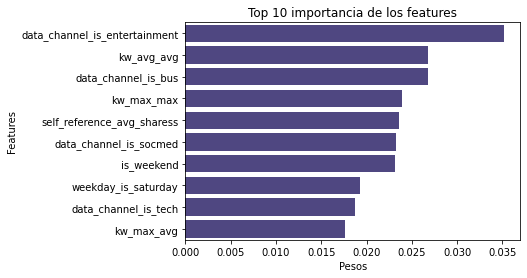

In [ ]:
plt.rcParams['figure.dpi'] = 120
sns.barplot(x=valores, y=features, color='#483D8B')
plt.title('Top 10 importancia de los features')
plt.xlabel('Pesos')
plt.ylabel('Features')
plt.show()